In [2]:
import warnings
from typing import Dict, Any, Tuple

import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
from monai.data import DataLoader, PersistentDataset
from monai.inferers import sliding_window_inference
from monai.losses import DiceCELoss
from monai.metrics import DiceHelper
from monai.networks.nets import UNet
import monai.transforms as T
from pytorch_lightning.loggers import TensorBoardLogger
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchmetrics.classification import MultilabelRecall, MultilabelAUROC, MultilabelPrecision
from transformers import get_linear_schedule_with_warmup
import pandas as pd
import numpy as np
from pathlib import Path
from pprint import pprint

import os

SEG_DIR = '/home/tibia/Projet_Hemorragie/Seg_hemorragie/split_MONAI'
CLASSIFICATION_DATA_DIR = '/home/tibia/Projet_Hemorragie/MBH_label_case'
SAVE_DIR = "/home/tibia/Projet_Hemorragie/MBH_multitask_log"
os.makedirs(SAVE_DIR, exist_ok=True)

NUM_CLASSES = 6
CLASS_NAMES = ['any', 'epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/home/tibia/Projet_Hemorragie/hemorragie-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
def get_segmentation_data(split="train"):
    img_dir = Path(SEG_DIR) / split / "img"
    seg_dir = Path(SEG_DIR) / split / "seg"
    
    images = sorted(img_dir.glob("*.nii.gz"))
    labels = sorted(seg_dir.glob("*.nii.gz"))
    
    assert len(images) == len(labels), "Mismatch between image and label counts"

    data = []
    for img, lbl in zip(images, labels):
        data.append({
            "image": str(img),
            "label": str(lbl),
            "task": "segmentation"
        })
        
    return data

def get_classification_data(split="train"):
    csv_path = Path(CLASSIFICATION_DATA_DIR) / "splits" / f"{split}_split.csv"
    df = pd.read_csv(csv_path)
    nii_dir = Path(CLASSIFICATION_DATA_DIR)
    label_cols = ['any', 'epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']
    
    data = []
    for _, row in df.iterrows():
        image_path = str(nii_dir / f"{row['patientID_studyID']}.nii.gz")
        label = np.array([row[col] for col in label_cols], dtype=np.float32)
        
        data.append({
            "image": image_path,
            "label": label,
            "task": "classification"
        })
    return data


def get_balanced_classification_data(split="train", target_size=None):
    csv_path = Path(CLASSIFICATION_DATA_DIR) / "splits" / f"{split}_split.csv"
    df = pd.read_csv(csv_path)
    nii_dir = Path(CLASSIFICATION_DATA_DIR)
    label_cols = ['any', 'epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']
    
    # Identifier les cas positifs (au moins une hémorragie)
    df['is_positive'] = df[label_cols].sum(axis=1) > 0
    
    # Séparer positifs et négatifs
    positives = df[df['is_positive']]
    print(f"Nombre de cas positifs : {len(positives)}")
    negatives = df[~df['is_positive']]
    print(f"Nombre de cas négatifs : {len(negatives)}")
    
    # Équilibrer le dataset si une taille cible est spécifiée
    if target_size:
        n_pos = len(positives)
        n_neg = target_size - n_pos
        
        # Sous-échantillonnage des négatifs si nécessaire
        if len(negatives) > n_neg:
            negatives = negatives.sample(n_neg, random_state=42)
        
        # Combiner et mélanger
        balanced_df = pd.concat([positives, negatives]).sample(frac=1, random_state=42)
    else:
        balanced_df = df
    
    data = []
    for _, row in balanced_df.iterrows():
        image_path = str(nii_dir / f"{row['patientID_studyID']}.nii.gz")
        label = np.array([row[col] for col in label_cols], dtype=np.float32)
        
        data.append({
            "image": image_path,
            "label": label,
            "task": "classification"
        })
    
    return data

def get_optimized_classification_data(split="train", seg_count=154):
    csv_path = Path(CLASSIFICATION_DATA_DIR) / "splits" / f"{split}_split.csv"
    df = pd.read_csv(csv_path)
    nii_dir = Path(CLASSIFICATION_DATA_DIR)
    label_cols = ['any', 'epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']
    
    # Identifier les cas positifs (au moins une hémorragie)
    df['is_positive'] = df[label_cols].sum(axis=1) > 0
    positives = df[df['is_positive']]
    negatives = df[~df['is_positive']]
    
    # Stratégie différente pour train/val
    
        # TRAIN : On garde TOUS les positifs (371) même si >2x seg_count
    selected_pos = positives
    needed_neg = max(0, 2*seg_count - len(selected_pos))
    selected_neg = negatives.sample(min(needed_neg, len(negatives)), random_state=42) if needed_neg > 0 else pd.DataFrame()
    
    
    balanced_df = pd.concat([selected_pos, selected_neg]).sample(frac=1, random_state=42)
    
    # Statistiques
    print(f"{split.upper()} - Positifs: {len(selected_pos)}/{len(positives)} | Négatifs: {len(selected_neg)}")
    
    return [{
        "image": str(nii_dir / f"{row['patientID_studyID']}.nii.gz"),
        "label": np.array([row[col] for col in label_cols], dtype=np.float32),
        "task": "classification"
    } for _, row in balanced_df.iterrows()]
    
    
def get_multitask_dataset(split="train"):
    seg_data = get_segmentation_data(split)
    cls_data = get_classification_data(split)
    return seg_data + cls_data

def get_balanced_multitask_dataset(split="train"):
    seg_data = get_segmentation_data(split)
    seg_count = len(seg_data)
    cls_data = get_optimized_classification_data(split, seg_count)
    print(f"Nombre de données de segmentation : {len(seg_data)}")
    print(f"Nombre de données de classification : {len(cls_data)}")
    return seg_data + cls_data

# new_segmentation_data = get_segmentation_data("train")
# print(f"Nombre de données de segmentation : {len(new_segmentation_data)}")

# val_segmentation_data = get_segmentation_data("val")
# print(f"Nombre de données de validation de segmentation : {len(val_segmentation_data)}")

# target_size_train = 2*len(new_segmentation_data) # Taille cible pour l'équilibrage
# target_size_val = 2*len(val_segmentation_data) # Taille cible pour l'équilibrage




# new_classification_data = get_balanced_classification_data("train", target_size=target_size_train)
# print(f"Nombre de données de classification : {len(new_classification_data)}")
# val_classification_data = get_balanced_classification_data("val", target_size=target_size_val)
# print(f"Nombre de données de validation de classification : {len(val_classification_data)}")

new_multitask_data = get_balanced_multitask_dataset("train")
print(f"Nombre total de données multitâches : {len(new_multitask_data)}")

val_multitask_data = get_balanced_multitask_dataset("val")
print(f"Nombre total de données multitâches de validation : {len(val_multitask_data)}")
# print(f"Exemples de données multitâches : {new_multitask_data[:2]}")
# # regarder les clés des dictionnaires
# print(f"Clés des dictionnaires : {new_multitask_data[0].keys()}")


# from collections import Counter
# counter = Counter([sample["task"] for sample in new_multitask_data])
# print(f"Répartition des tâches : {dict(counter)}")

TRAIN - Positifs: 371/371 | Négatifs: 0
Nombre de données de segmentation : 154
Nombre de données de classification : 371
Nombre total de données multitâches : 525
VAL - Positifs: 92/92 | Négatifs: 0
Nombre de données de segmentation : 38
Nombre de données de classification : 92
Nombre total de données multitâches de validation : 130


In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

csv_path = Path("/home/tibia/Projet_Hemorragie/MBH_label_case/case-wise_annotation.csv")
label_cols = ['any', 'epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']
df = pd.read_csv(csv_path)

def visualize_label_distribution(label_file_counts, total_files):
    fig = plt.figure(figsize=(20, 12))
    
    labels = list(range(6))
    counts = [label_file_counts[i] for i in labels]
    label_names = ['Background', 'EDH', 'IPH', 'IVH', 'SAH', 'SDH']
    
    colors = ['#2C3E50', '#E74C3C', '#3498DB', '#F39C12', '#9B59B6', '#1ABC9C']
    
    ax1 = plt.subplot(2, 3, 1)
    bars = ax1.bar(labels, counts, color=colors, alpha=0.8, edgecolor='black', linewidth=1)
    ax1.set_xlabel('Label', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Number of Files', fontsize=12, fontweight='bold')
    ax1.set_title('Files Containing Each Label', fontsize=14, fontweight='bold')
    ax1.set_xticks(labels)
    ax1.grid(axis='y', alpha=0.3)
    
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{count}', ha='center', va='bottom', fontweight='bold')
    
    ax2 = plt.subplot(2, 3, 2)
    percentages = [(count/total_files)*100 for count in counts]
    bars2 = ax2.barh(label_names, percentages, color=colors, alpha=0.8, edgecolor='black', linewidth=1)
    ax2.set_xlabel('Percentage of Files (%)', fontsize=12, fontweight='bold')
    ax2.set_title('Percentage Distribution', fontsize=14, fontweight='bold')
    ax2.grid(axis='x', alpha=0.3)
    
    for i, (bar, pct) in enumerate(zip(bars2, percentages)):
        width = bar.get_width()
        ax2.text(width + 1, bar.get_y() + bar.get_height()/2.,
                f'{pct:.1f}%', ha='left', va='center', fontweight='bold')
    
    ax3 = plt.subplot(2, 3, 3)
    hemorrhage_counts = counts[1:]
    hemorrhage_labels = label_names[1:]
    hemorrhage_colors = colors[1:]
    
    wedges, texts, autotexts = ax3.pie(hemorrhage_counts, labels=hemorrhage_labels, 
                                       colors=hemorrhage_colors, autopct='%1.1f%%',
                                       startangle=90, explode=(0.05, 0.05, 0.05, 0.05, 0.05))
    ax3.set_title('Hemorrhage Types Distribution\n(Excluding Background)', fontsize=14, fontweight='bold')
    
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
    
    ax4 = plt.subplot(2, 3, 4)
    background_count = counts[0]
    lesion_counts = counts[1:]
    
    bottom = 0
    bar_width = 0.6
    
    ax4.bar('Dataset', background_count, bar_width, label='Background', 
            color=colors[0], alpha=0.8, edgecolor='black', linewidth=1)
    bottom += background_count
    
    for i, (count, color, name) in enumerate(zip(lesion_counts, colors[1:], label_names[1:])):
        ax4.bar('Dataset', count, bar_width, bottom=bottom, label=name,
                color=color, alpha=0.8, edgecolor='black', linewidth=1)
        bottom += count
    
    ax4.set_ylabel('Number of Files', fontsize=12, fontweight='bold')
    ax4.set_title('Stacked Distribution', fontsize=14, fontweight='bold')
    ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    ax5 = plt.subplot(2, 3, 5)
    wedges, texts = ax5.pie(counts, labels=labels, colors=colors, 
                           wedgeprops=dict(width=0.5), startangle=90)
    
    ax5.text(0, 0, f'Total\n{total_files}\nFiles', ha='center', va='center',
             fontsize=14, fontweight='bold')
    ax5.set_title('Complete Distribution\n(Donut Chart)', fontsize=14, fontweight='bold')
    
    ax6 = plt.subplot(2, 3, 6)
    ax6.axis('off')
    
    summary_data = []
    for i, (label, count, name) in enumerate(zip(labels, counts, label_names)):
        pct = (count/total_files)*100
        summary_data.append([f'Label {label}', name, count, f'{pct:.1f}%'])
    
    summary_data.append(['', 'TOTAL FILES', total_files, '100.0%'])
    summary_data.append(['', 'Files w/ Lesions', (df['any'] == 1).sum(), ''])
    
    table = ax6.table(cellText=summary_data,
                     colLabels=['Label', 'Type', 'Count', 'Percentage'],
                     cellLoc='center',
                     loc='center',
                     colWidths=[0.15, 0.45, 0.2, 0.2])
    
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)
    
    for i in range(len(summary_data) + 1):
        for j in range(4):
            cell = table[(i, j)]
            if i == 0:
                cell.set_facecolor('#34495E')
                cell.set_text_props(weight='bold', color='white')
            elif i == len(summary_data) - 1 or i == len(summary_data):
                cell.set_facecolor('#ECF0F1')
                cell.set_text_props(weight='bold')
            else:
                cell.set_facecolor(colors[i-1] if i-1 < len(colors) else '#FFFFFF')
                if i-1 == 0:
                    cell.set_text_props(color='white', weight='bold')
    
    ax6.set_title('Summary Statistics', fontsize=14, fontweight='bold')
    
    plt.suptitle('Hemorrhage Dataset Annotation Distribution Analysis', 
                 fontsize=18, fontweight='bold', y=0.98)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    plt.show()
    
    print("\n" + "="*60)
    print("SUMMARY STATISTICS")
    print("="*60)
    print(f"Total files: {total_files}")
    print(f"Files with background (Label 0): {counts[0]} ({counts[0]/total_files*100:.1f}%)")
    print("Files with hemorrhage types:")
    for i in range(1, 6):
        pct = (counts[i]/total_files)*100
        print(f"  Label {i}: {counts[i]} files ({pct:.1f}%)")
    
    total_lesion_files_present = (df['any'] == 1).sum()
    print(f"\nFiles with at least one hemorrhage (any=1): {total_lesion_files_present}")

total_files = len(df)
label_file_counts = [0] * 6
label_file_counts[0] = (df['any'] == 0).sum() # Background (no hemorrhage)
label_file_counts[1] = (df['epidural'] == 1).sum()
label_file_counts[2] = (df['intraparenchymal'] == 1).sum()
label_file_counts[3] = (df['intraventricular'] == 1).sum()
label_file_counts[4] = (df['subarachnoid'] == 1).sum()
label_file_counts[5] = (df['subdural'] == 1).sum()

visualize_label_distribution(label_file_counts, total_files)

In [7]:
class TaskBasedTransform(T.MapTransform):
    """
    Applique un pipeline différent selon la tâche : "segmentation" ou "classification".
    """
    def __init__(self, keys):
        super().__init__(keys)
        print(">>> TaskBasedTransform initialized")

        self.window_preset = {"window_center": 40, "window_width": 80}

        self.seg_pipeline = T.Compose([
            T.LoadImaged(keys=["image", "label"], image_only=True),
            T.EnsureChannelFirstd(keys=["image", "label"]),
            T.CropForegroundd(keys=["image", "label"], source_key='image'),
            T.Orientationd(keys=["image", "label"], axcodes='RAS'),
            T.Spacingd(keys=["image", "label"], pixdim=(1.0, 1.0, 1.0), mode=["bilinear", "nearest"]),
            T.SpatialPadd(keys=["image", "label"], spatial_size=(96, 96, 96)),
            T.ScaleIntensityRanged(
                keys=["image"],
                a_min=-10,
                a_max=140,
                b_min=0.0, b_max=1.0, clip=True
            ),
            T.RandCropByPosNegLabeld(
                keys=['image', 'label'],
                image_key='image',
                label_key='label',
                pos=5.0,
                neg=1.0,
                spatial_size=(96, 96, 96),
                num_samples=2
            ),
            T.RandFlipd(keys=["image", "label"], spatial_axis=[0, 1], prob=0.5),
            T.RandRotate90d(keys=["image", "label"], spatial_axes=(0, 1), prob=0.5),
            T.RandScaleIntensityd(keys=["image"], factors=0.02, prob=0.5),
            T.RandShiftIntensityd(keys=["image"], offsets=0.05, prob=0.5)
        ])

        self.cls_pipeline = T.Compose([
            T.LoadImaged(keys=["image"], image_only=True),
            T.EnsureChannelFirstd(keys=["image"]),
            T.Orientationd(keys=["image"], axcodes='RAS'),
            T.Spacingd(keys=["image"], pixdim=(1.0, 1.0, 1.0), mode="bilinear"),
            T.ResizeWithPadOrCropd(keys=["image"], spatial_size=(96,96,96)), #bof ( trop petit) pour classification mais on test
            T.ScaleIntensityRanged(
                keys=["image"],
                a_min=self.window_preset["window_center"] - self.window_preset["window_width"] // 2,
                a_max=self.window_preset["window_center"] + self.window_preset["window_width"] // 2,
                b_min=0.0, b_max=1.0, clip=True
            ),
            T.RandFlipd(keys=["image"], spatial_axis=[0, 1, 2], prob=0.5),
            T.RandRotate90d(keys=["image"], spatial_axes=(0, 1), prob=0.5),
            T.RandScaleIntensityd(keys=["image"], factors=0.1, prob=0.5),
            T.RandShiftIntensityd(keys=["image"], offsets=0.1, prob=0.5),
            T.ToTensord(keys=["image", "label"])
        ])
        
    def __call__(self, data):
        task = data["task"]
        if task == "segmentation":
            return self.seg_pipeline(data)
        elif task == "classification":
            return self.cls_pipeline(data)
        else:
            raise ValueError(f"Tâche inconnue : {task}")
        
def get_multitask_transforms():
    return TaskBasedTransform(keys=["image", "label"])
   

        
class TaskBasedValTransform(T.MapTransform):
    """
    Transformations de validation — une pipeline par tâche, sans augmentation aléatoire.
    """
    def __init__(self, keys):
        super().__init__(keys)
        print(">>> TaskBasedTransform initialized")
        self.window_preset = {"window_center": 40, "window_width": 80}
   # Loading transforms
  # Ensure we load both image and segmentation

 # who cares about the background ?
  # make sure all images are the same orientation
   # to isotropic spacing
 # make sure we have at least 96 slices

        self.seg_pipeline = T.Compose([
            T.Lambda(lambda x: print("Segmentation pipeline appelée") or x),
            T.LoadImaged(keys=["image", "label"], image_only=False),
            T.EnsureChannelFirstd(keys=["image", "label"]),
            T.CropForegroundd(keys=["image", "label"], source_key='image'),
            T.Orientationd(keys=["image", "label"], axcodes='RAS'),
            T.Spacingd(keys=["image", "label"], pixdim=(1., 1., 1.), mode=["bilinear", "nearest"]),
            T.SpatialPadd(keys=["image", "label"], spatial_size=(96, 96, 96)),
            T.ScaleIntensityRanged(
                keys=["image"],
                a_min=-10,
                a_max=140,
                b_min=0.0, b_max=1.0, clip=True
            )
        ])

        self.cls_pipeline = T.Compose([
            T.LoadImaged(keys=["image"], image_only=True),
            T.EnsureChannelFirstd(keys=["image"]),
            T.Orientationd(keys=["image"], axcodes='RAS'),
            T.Spacingd(keys=["image"], pixdim=(1.0, 1.0, 1.0), mode="bilinear"),
            T.ResizeWithPadOrCropd(keys=["image"], spatial_size=(96, 96, 96)),
            T.ScaleIntensityRanged(
                keys=["image"],
                a_min=self.window_preset["window_center"] - self.window_preset["window_width"] // 2,
                a_max=self.window_preset["window_center"] + self.window_preset["window_width"] // 2,
                b_min=0.0, b_max=1.0, clip=True
            ),
            T.ToTensord(keys=["image", "label"])
        ])


    def __call__(self, data):
        print("Pipeline called for task:", data["task"])
        if data["task"] == "segmentation":
            return self.seg_pipeline(data)
        elif data["task"] == "classification":
            return self.cls_pipeline(data)
        else:
            raise ValueError(f"Tâche inconnue : {data['task']}")
        
def get_multitask_val_transforms():

    return TaskBasedValTransform(keys=["image", "label"])



### Deboggage avec pprint

In [8]:
data = get_segmentation_data(split="train")
print("Nombre d'exemples :", len(data))

# On prend 1 échantillon
sample = data[0]
pprint(sample)

Nombre d'exemples : 154
{'image': '/home/tibia/Projet_Hemorragie/Seg_hemorragie/split_MONAI/train/img/ID_0237f3c9_ID_40015688b9.nii.gz',
 'label': '/home/tibia/Projet_Hemorragie/Seg_hemorragie/split_MONAI/train/seg/ID_0237f3c9_ID_40015688b9.nii.gz',
 'task': 'segmentation'}


In [19]:
# cell 4 : test pipeline 1 (TaskBasedTransform)
task_transforms = get_multitask_val_transforms()

print("=== TaskBasedTransform ===")
sample_transformed_task = task_transforms(sample.copy())  # Attention : .copy() pour ne pas modifier sample
print("Transformations terminées (TaskBasedTransform).")

print("Shape image :", sample_transformed_task["image"].shape)
print("Shape label :", sample_transformed_task["label"].shape)

>>> TaskBasedTransform initialized
=== TaskBasedTransform ===
Pipeline called for task: segmentation
Segmentation pipeline appelée
Transformations terminées (TaskBasedTransform).
Shape image : torch.Size([1, 200, 203, 138])
Shape label : torch.Size([1, 200, 203, 138])


In [21]:
# cell 5 : test pipeline 2 (Compose classique)
# Pipeline manuelle équivalente (extraites de la deuxième méthode)
manual_transforms = T.Compose([
    T.LoadImaged(keys=["image", "label"]),
    T.EnsureChannelFirstd(keys=["image", "label"]),
    T.CropForegroundd(keys=["image", "label"], source_key='image'),
    T.Orientationd(keys=["image", "label"], axcodes='RAS'),
    T.Spacingd(keys=["image", "label"], pixdim=(1.0, 1.0, 1.0), mode=["bilinear", "nearest"]),
    T.SpatialPadd(keys=["image", "label"], spatial_size=(96, 96, 96)),
    T.ScaleIntensityRanged(
        keys=["image"],
        a_min=-10,
        a_max=140,
        b_min=0.0,
        b_max=1.0,
        clip=True
    )
#     T.RandCropByPosNegLabeld(
#         keys=["image", "label"],
#         image_key="image",
#         label_key="label",
#         pos=5.0,
#         neg=1.0,
#         spatial_size=(96, 96, 96),
#         num_samples=2
#     ),
#     T.RandFlipd(keys=["image", "label"], spatial_axis=[0, 1], prob=0.5),
#     T.RandRotate90d(keys=["image", "label"], spatial_axes=(0, 1), prob=0.5),
#     T.RandScaleIntensityd(keys=["image"], factors=0.02, prob=0.5),
#     T.RandShiftIntensityd(keys=["image"], offsets=0.05, prob=0.5)
 ])

print("=== Pipeline classique ===")
sample_transformed_manual = manual_transforms(sample.copy())
print("Transformations terminées (Pipeline classique).")

print("Shape image :", sample_transformed_manual["image"].shape)
print("Shape label :", sample_transformed_manual["label"].shape)


=== Pipeline classique ===
Transformations terminées (Pipeline classique).
Shape image : torch.Size([1, 200, 203, 138])
Shape label : torch.Size([1, 200, 203, 138])


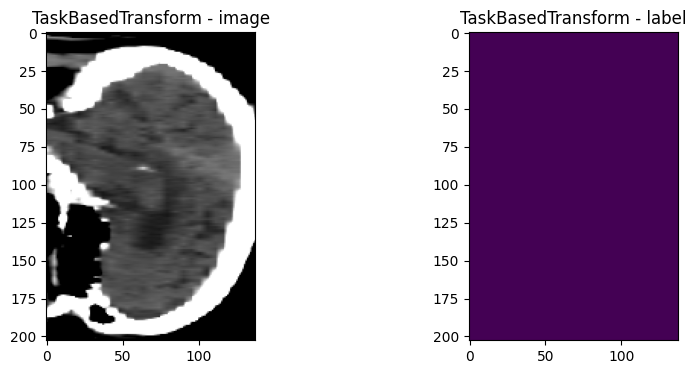

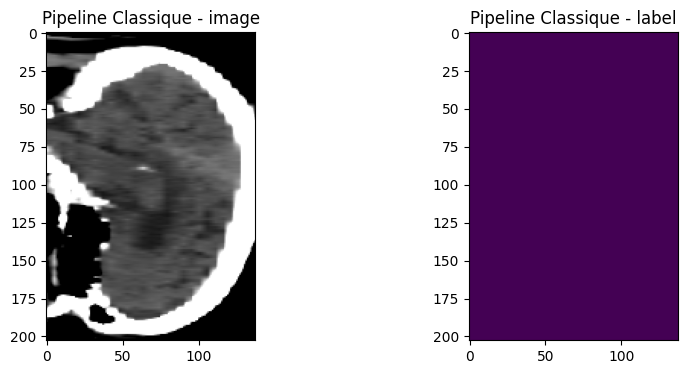

In [22]:
import matplotlib.pyplot as plt
# cell 6 : affichage image slice centrale (juste visuel)
def show_slice(image, label, title):
    # Affiche une coupe axiale centrale
    slice_idx = image.shape[1] // 2
    img_slice = image[0, slice_idx]
    lbl_slice = label[0, slice_idx]
    
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img_slice, cmap="gray")
    plt.title(f"{title} - image")
    
    plt.subplot(1, 2, 2)
    plt.imshow(lbl_slice)
    plt.title(f"{title} - label")
    plt.show()

# task-based
show_slice(sample_transformed_task["image"].cpu().numpy(), sample_transformed_task["label"].cpu().numpy(), "TaskBasedTransform")

# pipeline 2
show_slice(sample_transformed_manual["image"].cpu().numpy(), sample_transformed_manual["label"].cpu().numpy(), "Pipeline Classique")


In [17]:
print("Comparaison des types :")
print("Type image task :", type(sample_transformed_task["image"]))
print("Type image manual :", type(sample_transformed_manual["image"]))

print("\nVérification dimensions")
print("task:", sample_transformed_task["image"].shape)
print("manual:", sample_transformed_manual["image"].shape)

print("\nExemples de stats (image):")
print("Task mean:", sample_transformed_task["image"].mean().item())
print("Manual mean:", sample_transformed_manual["image"].mean().item())

Comparaison des types :
Type image task : <class 'monai.data.meta_tensor.MetaTensor'>
Type image manual : <class 'monai.data.meta_tensor.MetaTensor'>

Vérification dimensions
task: torch.Size([1, 96, 96, 96])
manual: torch.Size([1, 96, 96, 96])

Exemples de stats (image):
Task mean: 0.43183043599128723
Manual mean: 0.39937624335289


In [38]:
from monai.data.utils import list_data_collate
warnings.filterwarnings("ignore", message="You are using `torch.load` with `weights_only=False`")

def flatten(batch):
    for item in batch:
        if isinstance(item, list):
            yield from flatten(item)
        else:
            yield item

def multitask_collate_fn(batch):
    print(">>> multitask_collate_fn called")
    
    flat_batch = list(flatten(batch))  

    classification_batch = []
    segmentation_batch = []

    for item in flat_batch:
        # if item["task"] == "classification":
        #     classification_batch.append(item)
        if item["task"] == "segmentation":

            segmentation_batch.append(item)
            print(f"Item de segmentation bien ajouté : {item['image']}")
        else:
            raise ValueError(f"Tâche inconnue : {item['task']}")

    result = {
        "classification": list_data_collate(classification_batch) if classification_batch else None,
        "segmentation": list_data_collate(segmentation_batch) if segmentation_batch else None
    }
    
    return result


    
        
from monai.data import Dataset
batch_size = 2

train_data= get_segmentation_data("train") 
val_data = get_segmentation_data("val")
    
print(f"Training samples: {len(train_data)}")
print(f"Validation samples: {len(val_data)}")
    
    # Transforms
train_transforms, val_transforms = get_multitask_transforms(), get_multitask_val_transforms()
print (train_transforms)
    
    # Datasets
train_dataset = Dataset(
        train_data,
        transform=train_transforms,
   
    )
    
val_dataset = Dataset(
        val_data,
        transform=val_transforms,
       
    )
    
    # DataLoaders
train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True, 
        num_workers=8,
        persistent_workers=True,
        collate_fn=multitask_collate_fn
    )
    
val_loader = DataLoader(
        val_dataset, 
        batch_size=1, # ou 2 
        shuffle=False, 
        num_workers=8,
        persistent_workers=True,
        collate_fn=multitask_collate_fn
    )

    

print(f"Training DataLoader: {len(train_loader)} batches")
print(f"Validation DataLoader: {len(val_loader)} batches")

sample = train_dataset[0]  # Prendre le premier échantillon pour l'inspection







def inspect_data(data):
    if isinstance(data, list):
        for i, item in enumerate(data):
            print(f"Sample {i}:")
            print("Image shape:", item["image"].shape)
            print("Image min/max:", item["image"].min(), item["image"].max())
            #lister metadonnées pour pixdim et orientation
            print(f"list of metadatata : {item['image'].meta.keys()}" )
            # Vérifier les métadonnées pour pixdim et orientation
            if hasattr(item["image"], "meta") and "spacing" in item["image"].meta:
                print("Image spacing:", item["image"].meta["spacing"])
            else:
                print("Image spacing: Not available")
           
             
                
       
                print("Image orientation: Not available")
            if "label" in item:
                print("Label shape:", item["label"].shape)
                
                
            print("Task:", item["task"])
    else:
        print("Image shape:", data["image"].shape)
        print("Image min/max:", data["image"].min(), data["image"].max())
        if hasattr(item["image"], "meta") and "spacing" in item["image"].meta:
            print("Image spacing:", item["image"].meta["spacing"])
        else:
            print("Image spacing: Not available")
    
            print("Label shape:", data["label"].shape)
           
  
           
        print("Task:", data["task"])

inspect_data(sample)

# print("\n>>> Test DataLoader iteration")
# for batch in train_loader:
#     print("Batch loaded !")
#     break 

print("\n>>> Test direct appel train_dataset[0] :")
_ = train_dataset[0]



Training samples: 154
Validation samples: 38
>>> TaskBasedTransform initialized
>>> TaskBasedTransform initialized
Training DataLoader: 77 batches
Validation DataLoader: 38 batches


/home/tibia/Projet_Hemorragie/hemorragie-env/lib/python3.12/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


Sample 0:
Image shape: torch.Size([1, 96, 96, 96])
Image min/max: metatensor(0.0461) metatensor(1.0611)
list of metadatata : dict_keys(['sizeof_hdr', 'extents', 'session_error', 'dim_info', 'dim', 'intent_p1', 'intent_p2', 'intent_p3', 'intent_code', 'datatype', 'bitpix', 'slice_start', 'pixdim', 'vox_offset', 'scl_slope', 'scl_inter', 'slice_end', 'slice_code', 'xyzt_units', 'cal_max', 'cal_min', 'slice_duration', 'toffset', 'glmax', 'glmin', 'qform_code', 'sform_code', 'quatern_b', 'quatern_c', 'quatern_d', 'qoffset_x', 'qoffset_y', 'qoffset_z', 'srow_x', 'srow_y', 'srow_z', affine, original_affine, 'as_closest_canonical', spatial_shape, space, original_channel_dim, 'filename_or_obj', 'patch_index', 'crop_center'])
Image spacing: Not available
Image orientation: Not available
Label shape: torch.Size([1, 96, 96, 96])
Task: segmentation
Sample 1:
Image shape: torch.Size([1, 96, 96, 96])
Image min/max: metatensor(0.) metatensor(1.)
list of metadatata : dict_keys(['sizeof_hdr', 'extents'

In [33]:
DATASET_DIR = '/home/tibia/Projet_Hemorragie/Seg_hemorragie/split_MONAI'
SAVE_DIR = "/home/tibia/Projet_Hemorragie/MBH_aug_low"
os.makedirs(SAVE_DIR, exist_ok=True)

def get_data_files(img_dir, seg_dir):
    images = sorted([os.path.join(img_dir, f) for f in os.listdir(img_dir) if f.endswith('.nii.gz')])
    labels = sorted([os.path.join(seg_dir, f) for f in os.listdir(seg_dir) if f.endswith('.nii.gz')])
    return [{"image": img, "seg": lbl} for img, lbl in zip(images, labels)]

transforms = T.Compose([
    # Loading transforms
    T.LoadImaged(keys=["image", "seg"], image_only=False,overwriting=True),  # Ensure we load both image and segmentation
    T.EnsureChannelFirstd(keys=["image", "seg"]),
    T.CropForegroundd(keys=['image', 'seg'], source_key='image'), # who cares about the background ?
    T.Orientationd(keys=["image", "seg"], axcodes='RAS'),  # make sure all images are the same orientation
    T.Spacingd(keys=["image", "seg"], pixdim=(1., 1., 1.), mode=['bilinear', 'nearest']), # to isotropic spacing
    T.SpatialPadd(keys=["image", "seg"], spatial_size=(96, 96, 96)),  # make sure we have at least 96 slices
    T.ScaleIntensityRanged(keys=["image"], a_min=-10, a_max=140, b_min=0.0, b_max=1.0, clip=True),  # clip images

    # Let's crop 2 patches per case using positive negative instead of class by class
    T.RandCropByPosNegLabeld(
       keys=['image', 'seg'],
       image_key='image',
       label_key='seg',
        pos=5.0,
        neg=1.0,
        spatial_size=(96, 96, 96),
        num_samples=2
    ),
    # T.RandCropByLabelClassesd(
    #     keys=["image", "seg"],
    #     label_key="seg",
    #     spatial_size=(128, 128, 64),  # Taille adaptée aux EDH/SDH
    #     num_classes=6,
    #     ratios=[0.1, 0.25, 0.15, 0.1, 0.2, 0.2],  # Priorité EDH(1), SAH(2)
    #     num_samples=4
    # ),
    # T.RandCropByLabelClassesd(
    # keys=["image", "seg"],
    # label_key="seg",
    # spatial_size=(96, 96, 96),  
    # num_classes=6,
    # ratios=[0.1, 0.3, 0.1, 0.1, 0.1, 0.1],  # + de poids pour les classes rares (classe 1 ici à 0.3 par ex)
    # num_samples=4, 
    # ),

    # Data augmentations
    # For intensity augmentations, small random transforms but often
    # For spatial augmentations, only along the sagittal and coronal axis
    T.RandScaleIntensityd(
        keys=['image'],
        factors=0.02,
        prob=0.5
    ),
    T.RandShiftIntensityd(
       keys=['image'],
        offsets=0.05,
        prob=0.5
    ),
    T.RandRotate90d(
        keys=['image', 'seg'],
        prob=0.5,
        max_k=2,
        spatial_axes=(0, 1)
    ),
    T.RandFlipd(
        keys=['image', 'seg'],
        prob=0.5,
        spatial_axis=[0, 1]
    )
    # T.RandAffined(
    # keys=['image', 'seg'],
    # prob=0.3,
    # rotate_range=(0, 0, 0.1),  # Petite rotation seulement en axial (Z)
    # scale_range=(0.1, 0.1, 0),  # Léger zoom dans le plan axial
    # mode=['bilinear', 'nearest'],
    # padding_mode='border'
    # ),

    # T.RandAdjustContrastd(
    # keys=['image'],
    # gamma=(0.7, 1.5),  # Gamme plus large pour capturer EDH subtils
    # prob=0.5
    # )
])

val_transforms = T.Compose([
    # Loading transforms
    T.LoadImaged(keys=["image", "seg"]),
    T.EnsureChannelFirstd(keys=["image", "seg"]),
    T.CropForegroundd(keys=['image', 'seg'], source_key='image'), # who cares about the background ?
    T.Orientationd(keys=["image", "seg"], axcodes='RAS'),  # make sure all images are the same orientation
    T.Spacingd(keys=["image", "seg"], pixdim=(1., 1., 1.), mode=['bilinear', 'nearest']), # to isotropic spacing
    T.SpatialPadd(keys=["image", "seg"], spatial_size=(96, 96, 96)),  # make sure we have at least 96 slices
    T.ScaleIntensityRanged(keys=["image"], a_min=-10, a_max=140, b_min=0.0, b_max=1.0, clip=True),  # clip images
])

print (transforms.keys)

AttributeError: 'Compose' object has no attribute 'keys'

In [73]:
def inspect_data(data):
    if isinstance(data, list):
        for i, item in enumerate(data):
            print(f"Sample {i}:")
            print("Image shape:", item["image"].shape)
            print("Image min/max:", item["image"].min(), item["image"].max())
            #lister metadonnées pour pixdim et orientation
            print(f"list of metadatata : {item['image'].meta.keys()}" )
            # Vérifier les métadonnées pour pixdim et orientation
            if hasattr(item["image"], "meta") and "pixdim" in item["image"].meta:
                print("Image pixdim:", item["image"].meta["pixdim"])
            else:
                print("Image pixdim: Not available")
           
             
                
       
                print("Image orientation: Not available")
            if "label" in item:
                print("Label shape:", item["label"].shape)
                if hasattr(item["label"], "meta") and "pixdim" in item["label"].meta:
                    print("Label pixdim:", item["label"].meta["pixdim"])
                else:
                    print("Label pixdim: Not available")
                

    else:
        print("Image shape:", data["image"].shape)
        print("Image min/max:", data["image"].min(), data["image"].max())
        if hasattr(data["image"], "meta") and "pixdim" in data["image"].meta:
            print("Image pixdim:", data["image"].meta["pixdim"])
        else:
            print("Image pixdim: Not available")
    
            print("Label shape:", data["label"].shape)
            if hasattr(data["label"], "meta") and "pixdim" in data["label"].meta:
                print("Label pixdim:", data["label"].meta["pixdim"])
            else:
                print("Label pixdim: Not available")
  
           





train_files = get_data_files(f"{DATASET_DIR}/train/img", f"{DATASET_DIR}/train/seg")
val_files = get_data_files(f"{DATASET_DIR}/val/img", f"{DATASET_DIR}/val/seg")


train_dataset = PersistentDataset(
        train_files,
        transform=transforms,
        cache_dir=os.path.join(SAVE_DIR, "cache_train")
    )

val_dataset = PersistentDataset(
        val_files,
        transform=val_transforms,
        cache_dir=os.path.join(SAVE_DIR, "cache_val")
    )

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=8)
print(f"Training DataLoader: {len(train_loader)} batches")
print(f"Validation DataLoader: {len(val_loader)} batches")

sample_1 = train_files[0]
print(f"Sample data: {sample_1}")


transformed_sample = transforms(sample_1)

inspect_data(transformed_sample)

Training DataLoader: 77 batches
Validation DataLoader: 38 batches
Sample data: {'image': '/home/tibia/Projet_Hemorragie/Seg_hemorragie/split_MONAI/train/img/ID_0237f3c9_ID_40015688b9.nii.gz', 'seg': '/home/tibia/Projet_Hemorragie/Seg_hemorragie/split_MONAI/train/seg/ID_0237f3c9_ID_40015688b9.nii.gz'}
Sample 0:
Image shape: torch.Size([1, 96, 96, 96])
Image min/max: metatensor(0.0380) metatensor(1.0380)
list of metadatata : dict_keys(['sizeof_hdr', 'extents', 'session_error', 'dim_info', 'dim', 'intent_p1', 'intent_p2', 'intent_p3', 'intent_code', 'datatype', 'bitpix', 'slice_start', 'pixdim', 'vox_offset', 'scl_slope', 'scl_inter', 'slice_end', 'slice_code', 'xyzt_units', 'cal_max', 'cal_min', 'slice_duration', 'toffset', 'glmax', 'glmin', 'qform_code', 'sform_code', 'quatern_b', 'quatern_c', 'quatern_d', 'qoffset_x', 'qoffset_y', 'qoffset_z', 'srow_x', 'srow_y', 'srow_z', affine, original_affine, 'as_closest_canonical', spatial_shape, space, original_channel_dim, 'filename_or_obj', 'p